In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import hickle

from ase.io import read

import torch
torch.set_default_dtype(torch.float64)
import numpy as np

from mlelec.data.dataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils._utils import blocks_to_matrix_opt as blocks_to_matrix

import metatensor.torch as mts
from metatensor.learn import DataLoader

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

In [3]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
}

device = 'cpu'

In [4]:
workdir = '../examples/data/water_1000'
frames = read(f'{workdir}/water_1000.xyz',':200')
fock = hickle.load(f'{workdir}/sto-3g/fock.hickle')[:200]
over = hickle.load(f'{workdir}/sto-3g/overlap.hickle')[:200]

In [5]:
qmdata = QMDataset(frames = frames, 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=fock,
                   overlap_realspace=list(over),
                   device = device, 
                   orbs = orbitals['sto-3g'], 
                   orbs_name = 'sto-3g'
                )

In [6]:
max_radial  = 8
max_angular = 4
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [7]:
mldata = MLDataset(qmdata, 
                   item_names = ['fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   features = None,#mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                  )

cpu pair features
cpu single center features
cpu single center features
Features set
Items set


In [8]:
mldata._split_indices(train_frac = 0.8, val_frac = 0.2)
mldata._split_items(mldata.train_frac, mldata.val_frac, mldata.test_frac)

In [9]:
dl = DataLoader(mldata.train_dataset, batch_size = 40, collate_fn = mldata.group_and_join)

In [10]:
def rnd_herm(n, N):
    ''' n: number of matrices 
    N xN : dims of each matrix
    k = num k points 
    '''

    num_samples = (n, N, N)
    
    a = torch.normal(0, 1, num_samples, dtype = torch.float64)
    final_samples = a + a.transpose(1,2).conj()
    
    return final_samples

In [11]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata.basis, 
                            device = device,
                            nhidden = 8, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()
NEPOCHS = 0

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [13]:
checkpoint = torch.load('../examples/data/water_rnd_eigvals.ckpt')
print('loaded $$$$$')

loaded $$$$$


In [14]:
NEPOCHS = checkpoint['epoch']

In [15]:
NEPOCHS

999

In [16]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [17]:
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [18]:
n = 100
targets = [rnd_herm(n, f.shape[0]) for f in mldata.items['fock_realspace']] 

In [19]:
eig_var = torch.cat([m.flatten() for m in mldata.items['eigenvalues']]).norm()**2
tar_var = torch.cat([torch.einsum('nij,ji->n', targets[A], mldata.items['density_matrix'][A].real).flatten() for A in range(len(qmdata))]).norm()**2

In [20]:
def compute_eigval_vec(dataset, batch, Hk, return_rho = False):
    eig = []
    rho = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_realspace):
        # Compute eigenvalues and eigenvectors
        # eigvals, eigvecs = symeig(Ax, M = Mx)
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M = xitorch.LinearOperator.m(S))
        if return_rho:
            frame = dataset.structures[A]
            natm = len(frame)
            ncore = sum(dataset.ncore[s] for s in frame.numbers)
            nelec = sum(frame.numbers) - ncore
            occ = torch.tensor([2.0 if i <= nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            rho.append(torch.einsum('n,...in,...jn->ij...', occ, C, C.conj()))
        eig.append(eigvals)
    if return_rho:
        return eig, rho
    else:
        return eig

def compute_ard_vec(dataset, batch, HT, device):
    basis = dataset.basis
    ard_ = []
    eig = []
    
    for A, H, S in zip(batch.sample_id, HT, batch.overlap_realspace):
        frame = dataset.structures[A]
        natm = len(frame)
        ncore = sum(dataset.ncore[s] for s in frame.numbers)
        nelec = sum(frame.numbers) - ncore
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        
        occ = torch.tensor([2.0 if i <= nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
        P = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())

        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks


        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
        eig.append(eigvals)
    
    return eig, ard_

# TRAIN (if neeeeeeded)

In [21]:
alpha = 1
nepoch = 1000
losses = []
for epoch in range(NEPOCHS,NEPOCHS+nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_t = 0

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)
        HT = blocks_to_matrix(pred, qmdata, detach = False, structure_ids=batch.sample_id)
        HT = [h[0,0,0] for h in HT]
        
        pred_eigvals = compute_eigval_vec(qmdata, batch, HT, return_rho=False)
        # pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)
        # trace_loss = sum((torch.einsum('nij...,ji...->n...', targets[A], pred_rho[Ab] - batch.density_matrix[Ab]).real**2).sum() for Ab, A in enumerate(batch.sample_id))/tar_var
        loss_e = loss_fn(pred_eigvals, batch.eigenvalues)/eig_var
        loss = alpha*loss_e + trace_loss  #+ loss_fn(pred_ard, batch.atom_resolved_density)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss_e += loss_e.item()
        epoch_loss_t += trace_loss.item()
    
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {np.sqrt(epoch_loss):>15.10f} {np.sqrt(epoch_loss_e):>15.10f} {np.sqrt(epoch_loss_t):>15.10f}")

NameError: name 'trace_loss' is not defined

In [ ]:
plt.loglog(losses)

# Validate

In [22]:
val_dl = DataLoader(mldata.val_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)

In [23]:
# batch = next(iter(val_dl))
batch = next(iter(dl))
pred = model(batch.features, mldata.model_metadata)

In [24]:
HT = blocks_to_matrix(pred, qmdata, detach = True, structure_ids=batch.sample_id)
HT = [h[0,0,0] for h in HT]

# pred_eigvals = compute_eigval_vec(qmdata, batch, HT, return_rho=False)
pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)

In [25]:
n = 100
targets = [rnd_herm(n, f.shape[0]) for f in mldata.items['fock_realspace']] 

In [26]:
pred_trace = torch.cat([torch.einsum('nij...,ji...->n...', targets[A], pred_rho[Ab].detach()) for Ab, A in enumerate(batch.sample_id)])
true_trace = torch.cat([torch.einsum('nij...,ji...->n...', targets[A], batch.density_matrix[Ab].detach().real) for Ab, A in enumerate(batch.sample_id)])

Text(0.5, 1.0, 'Random hermitian targets')

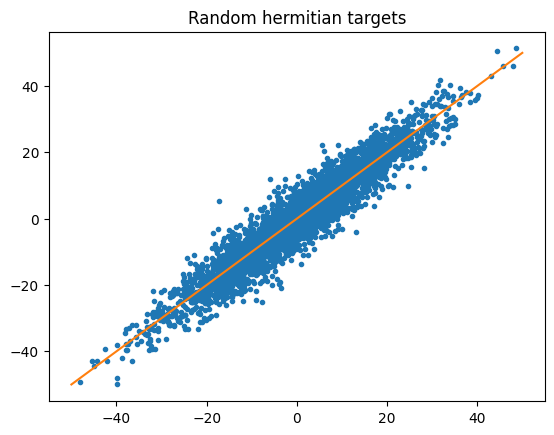

In [27]:
plt.plot(true_trace, pred_trace, '.')
plt.plot([-50, 50], [-50, 50])
plt.title('Random hermitian targets')

Text(0.5, 1.0, 'Eigenvalues')

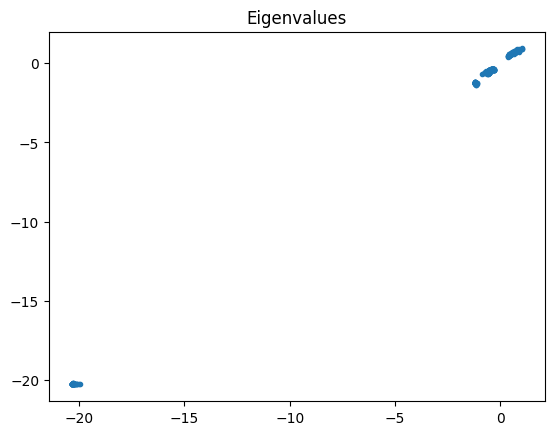

In [28]:
plt.plot(torch.cat(pred_eigvals).detach(), batch.eigenvalues.flatten(), '.')
# plt.plot([-21, 2], [-21, 2])
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.title('Eigenvalues')


In [29]:
pred_eig, pred_ard = compute_ard_vec(qmdata, batch, HT, device)

Text(0.5, 1.0, 'Mayer bond charges')

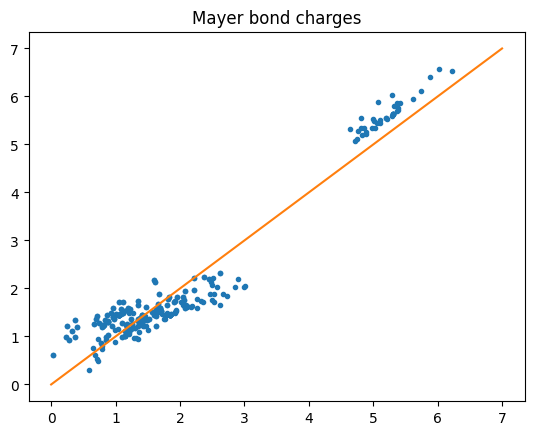

In [30]:
plt.plot(batch.atom_resolved_density.flatten(), torch.stack(pred_ard).detach().flatten(), '.')
plt.plot([0,7], [0,7])
plt.title('Mayer bond charges')

Text(0.5, 1.0, 'Eigenvalues')

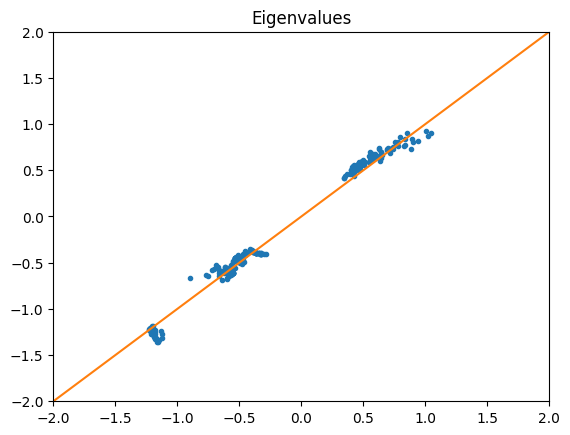

In [31]:
plt.plot(torch.cat(pred_eig).detach(), batch.eigenvalues.flatten(), '.')
plt.plot([-21, 2], [-21, 2])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Eigenvalues')


# Dipole 

In [32]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order

ModuleNotFoundError: No module named 'pyscfad'

In [ ]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

ModuleNotFoundError: No module named 'pyscfad'

In [ ]:
! pip install git+https://github.com/fishjojo/pyscfad.git@ml#egg=pyscfad

  Cloning https://github.com/fishjojo/pyscfad.git (to revision ml) to /tmp/pip-install-hb1epygi/pyscfad_b9f4557e5764455785ffe396af92751d
  Running command git clone --filter=blob:none --quiet https://github.com/fishjojo/pyscfad.git /tmp/pip-install-hb1epygi/pyscfad_b9f4557e5764455785ffe396af92751d
  Running command git checkout -b ml --track origin/ml
  Switched to a new branch 'ml'
  Branch 'ml' set up to track remote branch 'ml' from 'origin'.
  Resolved https://github.com/fishjojo/pyscfad.git to commit 8890c1a77cda8145409a105315f921ccb96fefc6
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.11.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached jax-0.4.30-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.30-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.0 kB)
  Using cached pyscf-2.3.0.tar.gz (8.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached pyscfadlib-0.1.4-py3-none-manylinux_2_17_x86_64.manylinux201

In [ ]:
fock_predictions = unfix_orbital_order(
    fock_predictions,
    ml_data.,
    ml_data.molecule_data.aux_data["orbitals"],
)

dipole_predictions = compute_dipole_moment(
    ml_data.test_frames,
    fock_predictions,
    ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
)

In [ ]:
test